In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
import seaborn as sns
import json

from service.app_api.features.extractor import FeatureExtractor
from configs import utils
from configs import settings

from catboost import CatBoostClassifier, Pool

import wandb
import shap
shap.initjs()

/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

In [12]:
try:
    customers, sales = joblib.load('customers.joblib'), joblib.load('sales.joblib')
except:
    customers, sales = pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_customers'), pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_sales')
    joblib.dump(customers, 'customers.joblib')
    joblib.dump(sales, 'sales.joblib')

In [13]:
fe = FeatureExtractor(target_month=3, perform_split=True, generation_type='categorical', filtering_set='customers', period=60, subperiod=15)

{'columns': None, 'values': 'prodcatbroad', 'index': 'ciid', 'aggfunc': 'pd.Series.nunique'}


In [14]:
X_train, X_test, y_train, y_test = fe.transform(sales=sales, customers=customers)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/fedorturchenko/.cache/huggingface/token
Login successful
Successfully logged out.


In [2]:
api = wandb.Api()
run = api.run(f"{settings.SETTINGS['WANDB_ENTITY']}/Cat-BoostClassifier/tkq50baj")

In [3]:
config = json.loads(run.json_config)
params = {}
for param in config:
    params.update({param: config[param]['value']})

In [ ]:
model = CatBoostClassifier(**params)
model.fit(X_train, y_train)

In [7]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_test, y_test, cat_features=params['cat_features']))

In [37]:
def plot_shapley_scatter(colname: str, shap_values: np.ndarray, data: pd.DataFrame, ncols: int):
    '''
    `colname` - initial column name (without `FeatureExtractor.subperiod` slicing)
    `shap_values` - array of shapley values
    `data` - training data frame, same shape as shap_values
    `ncols` - how many columns to fit charts in
    '''
    df_chart = pd.DataFrame(
        data={
            col: data.loc[:, col].values for col in data.columns if colname in col
        }
    )
    # data_type = df_chart.iloc[:, 0].dtype
    sub_plots = df_chart.shape[1]
    rows = sub_plots // ncols
    pos = range(1, sub_plots + 1)
    if sub_plots % ncols != 0:
        rows += 1

    fig = plt.figure(1)
    for i in range(sub_plots):
        ax = fig.add_subplot(rows, ncols, pos[i])
        current_feature = df_chart.iloc[:, i].name
        df_chart['shapley'] = shap_values[:, data.columns.tolist().index(current_feature)]
        if df_chart[current_feature].nunique() > 10:
            sns.scatterplot(data=df_chart, x=current_feature, y='shapley', ax=ax)
        else:
            sns.stripplot(data=df_chart, x=current_feature, y='shapley', ax=ax)

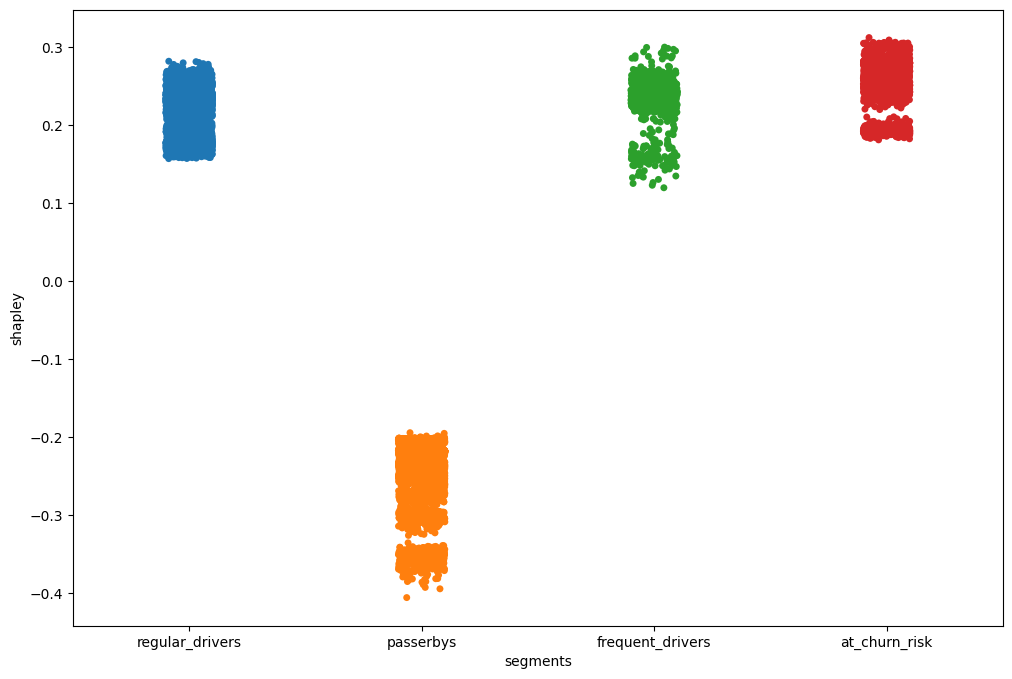

In [16]:
plot_shapley_scatter('segments', shap_values, X_test, ncols=1)

Customers of a "passerby" segment were more likely to be classified as churned. On the other hand, being in the churn risk group, does not itself imply that the customer is likely to churn.

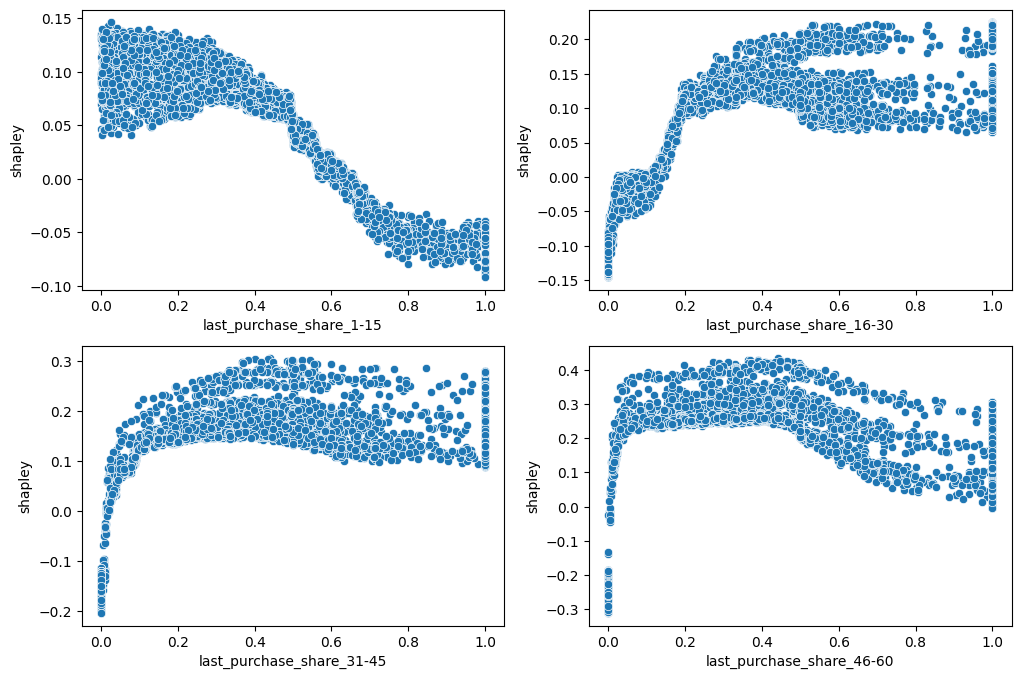

In [ ]:
plot_shapley_scatter('last_purchase_share', shap_values, X_test, ncols=2)

For each subperiod there was computed a share of last purchase (in terms of monetary value) from all the purchases made during this subperiod. For example, if a customer made 4 purchases with `qty` 25 each during the subperiod, then the `last_purchase_share = 0.25`.
- Day 1 to 15: High last purchase share implies that customer made a few purchases or even a single one during the very first days of activity. Such customers are more likely to churn due to this "passerby" kind of a consuming behavior. On the other hand, low last purchase share during first 15 days of being a client means that there will be quite some purchases in the subsequent periods.
- Day 16 to 30: Customers with a low, but non-zero (meaning that they actually purchased at least something), last purchase share are more likely to churn than to stay. It means that they made the majority of their purchases during first weeks. They made an insignificant purchase closer to the end of second 15 day period of activity, which could imply their overall dissatisfaction with the services.
- Day 31 to 45: If the last purchase share is at least around 10%, then it is quite likely for such customers to stay for the subsequent month. However, it is also important to mention that here the factor of making at least a single purchase during the second month of activity could influence such outcome.
- Day 46 to 60: The last purchase share of more than 50% during the end of a second month of activity implies, in fact, lower chance of completing at least a purchase next month. Yet, it is still only a sign of diminishing purchasing activity but not an absolute churn.

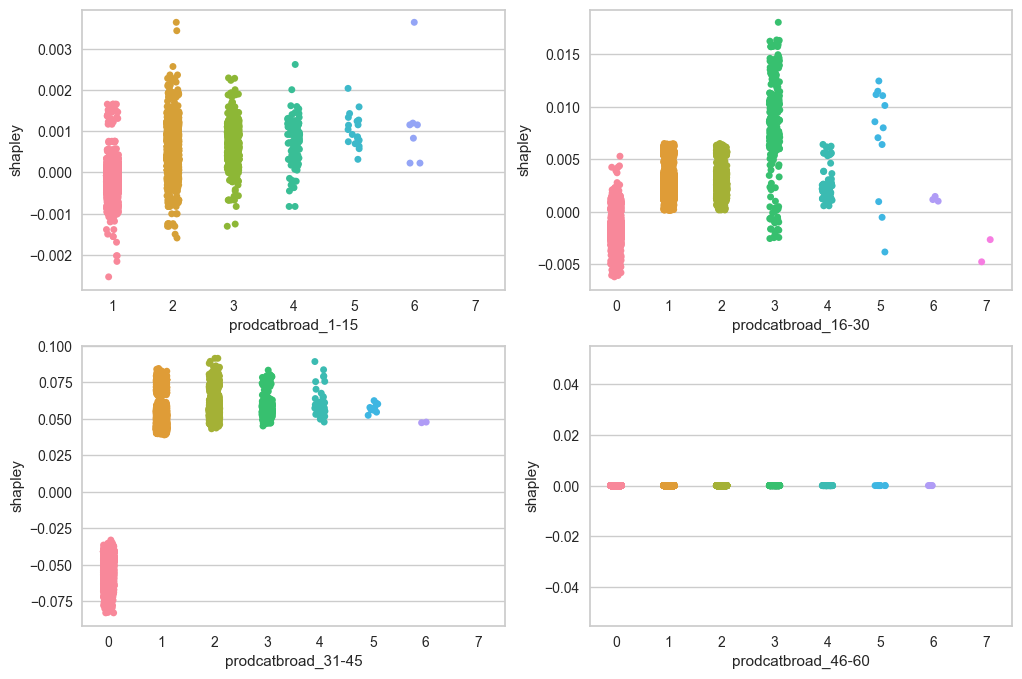

In [40]:
plot_shapley_scatter('prodcatbroad', shap_values, X_test, ncols=2)

For each subperiod, there was computed a number of purchases in unique categories. For example, if a customer at least once bought fuel and coffee, then `prodcatbroad_<subperiod> = 2`.
- Day 1 to 15: Purchases in any number of unique categories do not make a significant impact on probability of churn during the first 15 days of activity
- Day 16 to 30: 0 purchases during the second 15 day period of activity is a weak signal of potential churn. As for days 1 to 15, any non-zero number of unique categories, in which the purchase was made, does not significantly affect the resistance to churn
- Day 31 to 45: Crucial subperiod in this feature's terms. Even if, during this subperiod, the purchase was made in at least a single unique category, the customer is likely not to churn. While 0 purchases during this period is a strong indicator of churn
- Day 46 to 60: This feature has no impact at the subperiod of last 15 days within 60 days training data slice

In [8]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [9]:
clust_model = KMeans()
elbow_viz = KElbowVisualizer(clust_model, k=(1, 11))

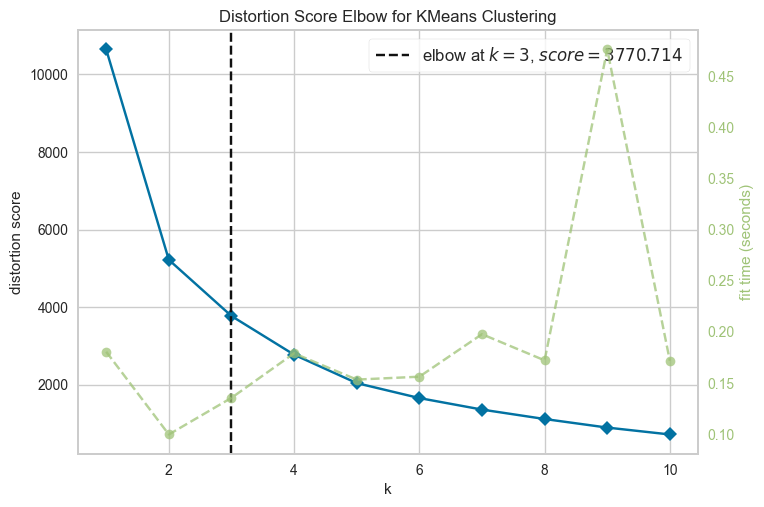

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
elbow_viz.fit(shap_values)
elbow_viz.show()

In [11]:
best_model = KMeans(3, random_state=571)
visualizer = SilhouetteVisualizer(best_model, colors='yellowbrick')

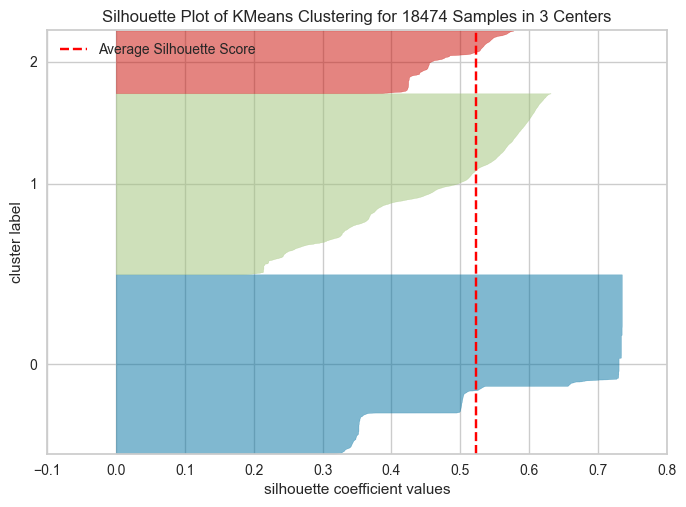

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 18474 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [12]:
visualizer.fit(shap_values)
visualizer.show()

In [12]:
labels = best_model.fit_predict(shap_values)
X_shap = X_test.copy()
X_shap['shap_clustering_labels'] = labels
X_shap['target'] = y_test
X_shap['predicted_target'] = model.predict(X_test)
probas = model.predict_proba(X_test)
X_shap['proba_0'] = probas[:, 0]
X_shap['proba_1'] = probas[:, 1]
X_shap['predicted_probability'] = X_shap.apply(lambda x: x['proba_0'] if x['predicted_target']==0 else x['proba_1'], axis=1)
X_shap['prediction_accuracy'] = X_shap.apply(lambda x: 'error' if x['target']!=x['predicted_target'] else 'correct', axis=1)

In [13]:
X_shap['shap_clustering_labels'].value_counts()

1    7903
0    7833
2    2738
Name: shap_clustering_labels, dtype: int64

In [14]:
(X_shap.groupby('shap_clustering_labels')['target'].value_counts(normalize=True)*100).sort_index().to_frame()

target
shap_clustering_labels target           
0                      0       78.028852
                       1       21.971148
1                      0       16.550677
                       1       83.449323
2                      0       43.206720
                       1       56.793280

In [28]:
X_shap.groupby('shap_clustering_labels')['predicted_probability'].describe()[['mean', '50%']].sort_index()

,mean,50%
shap_clustering_labels,,
0,0.757531,0.813131
1,0.816762,0.869589
2,0.586142,0.587577


Average predictions confidence in shapley values cluster 2 is significantly lower than in two other ones

In [35]:
(X_shap.groupby('shap_clustering_labels')['prediction_accuracy'].value_counts(normalize=True)*100).sort_index().to_frame()

prediction_accuracy
shap_clustering_labels prediction_accuracy                     
0                      correct                        78.028852
                       error                          21.971148
1                      correct                        83.550550
                       error                          16.449450
2                      correct                        60.262966
                       error                          39.737034

Quite expectedly, the model has made most of errors in the ambigous cluster 2

In [31]:
(X_shap.groupby('shap_clustering_labels')['segments'].value_counts(normalize=True)*100).sort_index().to_frame('segment_share')

segment_share
shap_clustering_labels                                
0                      regular_drivers        7.698200
                       passerbys             73.547811
                       frequent_drivers       0.868122
                       at_churn_risk         17.885867
1                      regular_drivers       51.398203
                       passerbys             22.991269
                       frequent_drivers       8.566367
                       at_churn_risk         17.044160
2                      regular_drivers       33.528123
                       passerbys             43.060628
                       frequent_drivers       3.688824
                       at_churn_risk         19.722425

Cluster 2 is composed of a mixture of various segments without any particular one really standing out, as it is the case for two other clusters